In [1]:
import torch
import torch.nn as nn

from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
# PARAMETRI

# run-aj na GPU-u ako mozes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# layers
input_layer = 2
hidden_layer = 25
output_layer = 1

# parametri
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
momentums = [0.5, 0.7, 0.9]
batch_size = 10

# epsilon
eps = 0.0000001


cuda


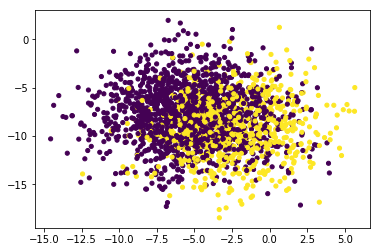

In [3]:
# pripremimo podatke
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=[2000, 1000], n_features=input_layer, centers=None, cluster_std=3)

X_test = torch.tensor(X[0:len(X)//4], dtype=torch.float) 
y_test = torch.tensor(y[0:len(y)//4], dtype=torch.float)
X, y = X[len(X)//4:], y[len(y)//4:]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.28)


X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)

X_val = torch.tensor(X_val, dtype=torch.float)
y_val = torch.tensor(y_val, dtype=torch.float)


plt.scatter(X[:,0], X[:,1], c=y, s=17, marker='o')

In [41]:
class NeuralNet(nn.Module):
    def __init__(self, input_l, hidden_l, output_l, alpha, momentum):
        self.alpha = alpha
        self.momentum = momentum
        self.name = 'I-' + str(input_l) + 'H-' + str(hidden_l) + 'O-' + str(output_l) + 'a-' + str(alpha) + 'm-' + str(momentum)
            
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_l, hidden_l)
        self.sigm = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_l, output_l)
        
    def forward(self, x):
        izlaz1 = self.sigm(self.fc1(x))
        izlaz2 = self.sigm(self.fc2(izlaz1))
        return izlaz2
    
    def train(self):
        print('\n\n')
        print('Trening neuronske mreze sa parametrima alpha: {} i momentum: {}'.format(alpha, momentum))
        
        criterion = nn.BCELoss()
        optimizer = optim.SGD(self.parameters(), lr=self.alpha, momentum=self.momentum)
        
        losses = []
        prekini_trening = False
        
        # promijeni u veci broj, npr. 4000-5000
        for epoch in range(1000):
            if(prekini_trening):
                break
            
            for i in range(0, len(X_train), batch_size):
                podaci = X_train[i:(i+batch_size), :]
                labele = y_train[i:(i+batch_size)].reshape(len(y_train[i:(i+batch_size)]), 1)

                podaci = Variable(podaci, requires_grad=True).to(device)
                labele = Variable(labele, requires_grad=False).to(device)

                # obrisi povijest operacija koje su se dogodile
                optimizer.zero_grad()

                # loss sadrzi sve operacije unazad (npr. input pa cijeli forward pa criterion) i na njemu
                # mozemo napraviti backpropagation preko funkcije backward
                outputs = self.forward(podaci)
                loss = criterion(outputs, labele)
                loss.backward()

                # updateaj novonastale weight-ove
                optimizer.step()

                # spremimo sve vrijednosti loss-eva
                if(i + batch_size >= len(X_train)):
                    greska = loss.data.cpu().numpy()
                
                    # broj 20 je tu stavljen bez nekog posebnog razloga, bitno je samo da
                    # losses[len(losses) - 1] ne baci gresku i da ne zaustavimo algoritam bas u prvih 20 epoha
                    if(len(losses) > 20 and abs(greska - losses[len(losses) - 1]) < eps):
                        prekini_trening = True
                        break
                        
                    losses.append(greska)
            
            print("Epoch {} - loss: {}".format(epoch, losses[len(losses) - 1]))
            
        return losses
        


In [35]:
# dodati F1 score umjesto accuracy-a
def accuracy(neural_net, X, y):
    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(0, len(X), batch_size):
            predicted = neural_net.forward(X[i:i+batch_size, :].to(device))
            total += len(X[i:i+batch_size, :])

            for j in range(len(predicted)):
                predicted[j] = 0 if predicted[j] < 0.5 else 1

            correct += (predicted == y[i:i+batch_size].reshape(len(y[i:i+batch_size]), 1).to(device)).sum().item()

        return 100 * correct / total
    

# funkcija koja sortira listu neural_nets silazno po accuracy-u
def sortiraj_mreze(neural_nets, eval_of_nets):
    for i in range(len(eval_of_nets) - 1):
        for j in range(len(eval_of_nets) - i - 1):
            if(eval_of_nets[j] < eval_of_nets[j+1]):
                eval_of_nets[j], eval_of_nets[j+1] =  eval_of_nets[j+1], eval_of_nets[j]
                neural_nets[j], neural_nets[j+1] =  neural_nets[j+1], neural_nets[j]




Trening neuronske mreze sa parametrima alpha: 0.001 i momentum: 0.55
Epoch 0 - loss: 0.5424862504005432
Epoch 1 - loss: 0.4866175651550293
Epoch 2 - loss: 0.4671139121055603
Epoch 3 - loss: 0.4580947160720825
Epoch 4 - loss: 0.4524921178817749
Epoch 5 - loss: 0.4480608403682709
Epoch 6 - loss: 0.44404852390289307
Epoch 7 - loss: 0.4402025640010834
Epoch 8 - loss: 0.4364425837993622
Epoch 9 - loss: 0.4327476918697357
Epoch 10 - loss: 0.42911794781684875
Epoch 11 - loss: 0.4255598187446594
Epoch 12 - loss: 0.4220815896987915
Epoch 13 - loss: 0.41869133710861206
Epoch 14 - loss: 0.4153963327407837
Epoch 15 - loss: 0.4122025668621063
Epoch 16 - loss: 0.40911513566970825
Epoch 17 - loss: 0.4061374068260193
Epoch 18 - loss: 0.4032720923423767
Epoch 19 - loss: 0.40052053332328796
Epoch 20 - loss: 0.3978830873966217
Epoch 21 - loss: 0.3953593969345093
Epoch 22 - loss: 0.39294835925102234
Epoch 23 - loss: 0.3906482458114624
Epoch 24 - loss: 0.38845667243003845
Epoch 25 - loss: 0.386370986700

Epoch 77 - loss: 0.3562709093093872
Epoch 78 - loss: 0.35632985830307007
Epoch 79 - loss: 0.35638660192489624
Epoch 80 - loss: 0.356441855430603
Epoch 81 - loss: 0.35649538040161133
Epoch 82 - loss: 0.35654744505882263
Epoch 83 - loss: 0.35659822821617126
Epoch 84 - loss: 0.35664796829223633
Epoch 85 - loss: 0.3566967248916626
Epoch 86 - loss: 0.356744647026062
Epoch 87 - loss: 0.3567918539047241
Epoch 88 - loss: 0.3568386137485504
Epoch 89 - loss: 0.35688498616218567
Epoch 90 - loss: 0.3569309413433075
Epoch 91 - loss: 0.35697686672210693
Epoch 92 - loss: 0.3570227324962616
Epoch 93 - loss: 0.3570684492588043
Epoch 94 - loss: 0.3571142554283142
Epoch 95 - loss: 0.3571603000164032
Epoch 96 - loss: 0.35720640420913696
Epoch 97 - loss: 0.35725292563438416
Epoch 98 - loss: 0.3572995364665985
Epoch 99 - loss: 0.35734665393829346
Epoch 100 - loss: 0.35739409923553467
Epoch 101 - loss: 0.35744184255599976
Epoch 102 - loss: 0.35749000310897827
Epoch 103 - loss: 0.3575385510921478
Epoch 104 - 

Epoch 298 - loss: 0.36283019185066223
Epoch 299 - loss: 0.36283743381500244
Epoch 300 - loss: 0.3628447353839874
Epoch 301 - loss: 0.36285218596458435
Epoch 302 - loss: 0.36285969614982605
Epoch 303 - loss: 0.3628672957420349
Epoch 304 - loss: 0.36287492513656616
Epoch 305 - loss: 0.3628826141357422
Epoch 306 - loss: 0.3628903925418854
Epoch 307 - loss: 0.3628983795642853
Epoch 308 - loss: 0.3629063665866852
Epoch 309 - loss: 0.36291447281837463
Epoch 310 - loss: 0.36292269825935364
Epoch 311 - loss: 0.36293092370033264
Epoch 312 - loss: 0.36293935775756836
Epoch 313 - loss: 0.3629477918148041
Epoch 314 - loss: 0.36295637488365173
Epoch 315 - loss: 0.3629651367664337
Epoch 316 - loss: 0.3629739582538605
Epoch 317 - loss: 0.36298274993896484
Epoch 318 - loss: 0.3629918098449707
Epoch 319 - loss: 0.36300092935562134
Epoch 320 - loss: 0.36301013827323914
Epoch 321 - loss: 0.3630194067955017
Epoch 322 - loss: 0.36302876472473145
Epoch 323 - loss: 0.36303818225860596
Epoch 324 - loss: 0.363

Epoch 518 - loss: 0.36451947689056396
Epoch 519 - loss: 0.3645247220993042
Epoch 520 - loss: 0.3645300567150116
Epoch 521 - loss: 0.3645353615283966
Epoch 522 - loss: 0.36454063653945923
Epoch 523 - loss: 0.3645457625389099
Epoch 524 - loss: 0.3645508587360382
Epoch 525 - loss: 0.3645559251308441
Epoch 526 - loss: 0.3645608723163605
Epoch 527 - loss: 0.36456596851348877
Epoch 528 - loss: 0.3645707666873932
Epoch 529 - loss: 0.36457565426826477
Epoch 530 - loss: 0.36458051204681396
Epoch 531 - loss: 0.364585280418396
Epoch 532 - loss: 0.36458998918533325
Epoch 533 - loss: 0.3645946681499481
Epoch 534 - loss: 0.36459919810295105
Epoch 535 - loss: 0.36460378766059875
Epoch 536 - loss: 0.3646083474159241
Epoch 537 - loss: 0.3646128475666046
Epoch 538 - loss: 0.364617258310318
Epoch 539 - loss: 0.364621639251709
Epoch 540 - loss: 0.3646259307861328
Epoch 541 - loss: 0.3646301031112671
Epoch 542 - loss: 0.36463436484336853
Epoch 543 - loss: 0.3646385967731476
Epoch 544 - loss: 0.364642679691

Epoch 76 - loss: 0.2999134659767151
Epoch 77 - loss: 0.3001228868961334
Epoch 78 - loss: 0.3003427982330322
Epoch 79 - loss: 0.30055510997772217
Epoch 80 - loss: 0.3007325232028961
Epoch 81 - loss: 0.300864577293396
Epoch 82 - loss: 0.3009601831436157
Epoch 83 - loss: 0.3010310232639313
Epoch 84 - loss: 0.301076740026474
Epoch 85 - loss: 0.301072359085083
Epoch 86 - loss: 0.30101194977760315
Epoch 87 - loss: 0.30100613832473755
Epoch 88 - loss: 0.30107879638671875
Epoch 89 - loss: 0.30114972591400146
Epoch 90 - loss: 0.3011927306652069
Epoch 91 - loss: 0.30121171474456787
Epoch 92 - loss: 0.3012135326862335
Epoch 93 - loss: 0.3012028932571411
Epoch 94 - loss: 0.3011823892593384
Epoch 95 - loss: 0.30115389823913574
Epoch 96 - loss: 0.3011186122894287
Epoch 97 - loss: 0.30107739567756653
Epoch 98 - loss: 0.30103111267089844
Epoch 99 - loss: 0.30098018050193787
Epoch 100 - loss: 0.3009254038333893
Epoch 101 - loss: 0.30086708068847656
Epoch 102 - loss: 0.300805926322937
Epoch 103 - loss: 

Epoch 296 - loss: 0.29391908645629883
Epoch 297 - loss: 0.29404115676879883
Epoch 298 - loss: 0.29418742656707764
Epoch 299 - loss: 0.2943626046180725
Epoch 300 - loss: 0.29457077383995056
Epoch 301 - loss: 0.2948131263256073
Epoch 302 - loss: 0.2950843274593353
Epoch 303 - loss: 0.2953680455684662
Epoch 304 - loss: 0.29563915729522705
Epoch 305 - loss: 0.2958766222000122
Epoch 306 - loss: 0.2960725724697113
Epoch 307 - loss: 0.2962297201156616
Epoch 308 - loss: 0.2963545620441437
Epoch 309 - loss: 0.296453595161438
Epoch 310 - loss: 0.2965320348739624
Epoch 311 - loss: 0.29659387469291687
Epoch 312 - loss: 0.29664236307144165
Epoch 313 - loss: 0.29667961597442627
Epoch 314 - loss: 0.29670771956443787
Epoch 315 - loss: 0.2967279851436615
Epoch 316 - loss: 0.2967417240142822
Epoch 317 - loss: 0.2967497706413269
Epoch 318 - loss: 0.29675304889678955
Epoch 319 - loss: 0.29675209522247314
Epoch 320 - loss: 0.2967476546764374
Epoch 321 - loss: 0.2967400848865509
Epoch 322 - loss: 0.29672980

Epoch 67 - loss: 0.35533297061920166
Epoch 68 - loss: 0.35570210218429565
Epoch 69 - loss: 0.3560768663883209
Epoch 70 - loss: 0.35645321011543274
Epoch 71 - loss: 0.35682445764541626
Epoch 72 - loss: 0.35718175768852234
Epoch 73 - loss: 0.35751500725746155
Epoch 74 - loss: 0.35781583189964294
Epoch 75 - loss: 0.3580787479877472
Epoch 76 - loss: 0.3583017885684967
Epoch 77 - loss: 0.35848522186279297
Epoch 78 - loss: 0.3586311936378479
Epoch 79 - loss: 0.3587431013584137
Epoch 80 - loss: 0.3588249087333679
Epoch 81 - loss: 0.3588812053203583
Epoch 82 - loss: 0.35891640186309814
Epoch 83 - loss: 0.3589349091053009
Epoch 84 - loss: 0.3589407205581665
Epoch 85 - loss: 0.35893693566322327
Epoch 86 - loss: 0.35892611742019653
Epoch 87 - loss: 0.35891032218933105
Epoch 88 - loss: 0.35889095067977905
Epoch 89 - loss: 0.3588690757751465
Epoch 90 - loss: 0.358845591545105
Epoch 91 - loss: 0.35882118344306946
Epoch 92 - loss: 0.35879623889923096
Epoch 93 - loss: 0.35877111554145813
Epoch 94 - lo

Epoch 289 - loss: 0.36829403042793274
Epoch 290 - loss: 0.3683179020881653
Epoch 291 - loss: 0.3683416545391083
Epoch 292 - loss: 0.36836501955986023
Epoch 293 - loss: 0.36838820576667786
Epoch 294 - loss: 0.36841121315956116
Epoch 295 - loss: 0.36843398213386536
Epoch 296 - loss: 0.36845648288726807
Epoch 297 - loss: 0.3684789538383484
Epoch 298 - loss: 0.3685012757778168
Epoch 299 - loss: 0.36852338910102844
Epoch 300 - loss: 0.36854541301727295
Epoch 301 - loss: 0.3685673177242279
Epoch 302 - loss: 0.36858904361724854
Epoch 303 - loss: 0.36861079931259155
Epoch 304 - loss: 0.3686324656009674
Epoch 305 - loss: 0.36865413188934326
Epoch 306 - loss: 0.36867576837539673
Epoch 307 - loss: 0.3686973452568054
Epoch 308 - loss: 0.3687189817428589
Epoch 309 - loss: 0.3687407076358795
Epoch 310 - loss: 0.36876246333122253
Epoch 311 - loss: 0.3687843084335327
Epoch 312 - loss: 0.36880630254745483
Epoch 313 - loss: 0.36882835626602173
Epoch 314 - loss: 0.36885058879852295
Epoch 315 - loss: 0.36

Epoch 509 - loss: 0.3701631724834442
Epoch 510 - loss: 0.37013310194015503
Epoch 511 - loss: 0.37010276317596436
Epoch 512 - loss: 0.37007221579551697
Epoch 513 - loss: 0.37004151940345764
Epoch 514 - loss: 0.37001049518585205
Epoch 515 - loss: 0.3699794411659241
Epoch 516 - loss: 0.3699481189250946
Epoch 517 - loss: 0.3699166476726532
Epoch 518 - loss: 0.36988508701324463
Epoch 519 - loss: 0.3698532283306122
Epoch 520 - loss: 0.3698213994503021
Epoch 521 - loss: 0.3697893023490906
Epoch 522 - loss: 0.36975717544555664
Epoch 523 - loss: 0.3697248697280884
Epoch 524 - loss: 0.36969244480133057
Epoch 525 - loss: 0.3696599304676056
Epoch 526 - loss: 0.36962732672691345
Epoch 527 - loss: 0.36959463357925415
Epoch 528 - loss: 0.3695618212223053
Epoch 529 - loss: 0.3695288896560669
Epoch 530 - loss: 0.36949583888053894
Epoch 531 - loss: 0.369462788105011
Epoch 532 - loss: 0.36942964792251587
Epoch 533 - loss: 0.3693963587284088
Epoch 534 - loss: 0.36936303973197937
Epoch 535 - loss: 0.369329

Epoch 729 - loss: 0.3624652326107025
Epoch 730 - loss: 0.36242905259132385
Epoch 731 - loss: 0.3623929023742676
Epoch 732 - loss: 0.3623567521572113
Epoch 733 - loss: 0.3623204231262207
Epoch 734 - loss: 0.36228418350219727
Epoch 735 - loss: 0.362248033285141
Epoch 736 - loss: 0.36221182346343994
Epoch 737 - loss: 0.3621755838394165
Epoch 738 - loss: 0.3621392250061035
Epoch 739 - loss: 0.3621029853820801
Epoch 740 - loss: 0.36206674575805664
Epoch 741 - loss: 0.3620305061340332
Epoch 742 - loss: 0.36199426651000977
Epoch 743 - loss: 0.36195796728134155
Epoch 744 - loss: 0.36192163825035095
Epoch 745 - loss: 0.36188530921936035
Epoch 746 - loss: 0.36184895038604736
Epoch 747 - loss: 0.36181268095970154
Epoch 748 - loss: 0.3617762327194214
Epoch 749 - loss: 0.36173996329307556
Epoch 750 - loss: 0.3617035746574402
Epoch 751 - loss: 0.361667275428772
Epoch 752 - loss: 0.361630916595459
Epoch 753 - loss: 0.36159446835517883
Epoch 754 - loss: 0.36155804991722107
Epoch 755 - loss: 0.36152166

Epoch 949 - loss: 0.3509479761123657
Epoch 950 - loss: 0.3508812487125397
Epoch 951 - loss: 0.3508153557777405
Epoch 952 - loss: 0.3507500886917114
Epoch 953 - loss: 0.350685715675354
Epoch 954 - loss: 0.3506220579147339
Epoch 955 - loss: 0.3505591154098511
Epoch 956 - loss: 0.3504968285560608
Epoch 957 - loss: 0.3504353165626526
Epoch 958 - loss: 0.3503745198249817
Epoch 959 - loss: 0.3503144085407257
Epoch 960 - loss: 0.3502548933029175
Epoch 961 - loss: 0.3501962125301361
Epoch 962 - loss: 0.3501381278038025
Epoch 963 - loss: 0.3500807583332062
Epoch 964 - loss: 0.3500239849090576
Epoch 965 - loss: 0.3499677777290344
Epoch 966 - loss: 0.34991222620010376
Epoch 967 - loss: 0.34985727071762085
Epoch 968 - loss: 0.3498029112815857
Epoch 969 - loss: 0.3497491478919983
Epoch 970 - loss: 0.34969595074653625
Epoch 971 - loss: 0.34964337944984436
Epoch 972 - loss: 0.3495912551879883
Epoch 973 - loss: 0.34953975677490234
Epoch 974 - loss: 0.34948867559432983
Epoch 975 - loss: 0.3494381904602

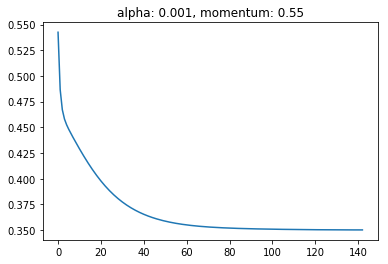

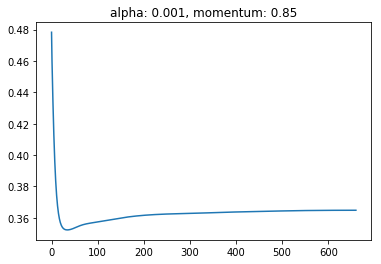

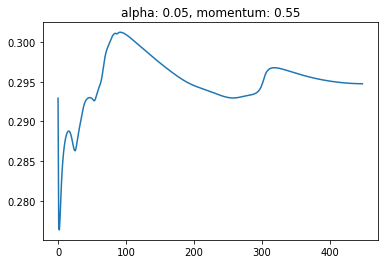

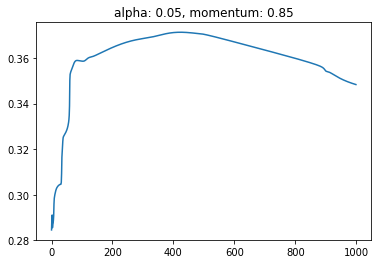

In [42]:
neural_nets  = []
eval_of_nets = []

# for alpha in alphas:
#     for momentum in momentums:
for alpha in [0.001, 0.05]:
    for momentum in [0.55, 0.85]:
        neural_net = NeuralNet(input_layer, hidden_layer, output_layer, alpha, momentum).to(device)
        losses = neural_net.train()

        # plotaj graf gresaka tijekom iteracija
        fig, ax = plt.subplots()
        ax.set_title('alpha: ' + str(neural_net.alpha) + ', momentum: ' + str(neural_net.momentum))
        ax.plot(losses)
        fig.savefig(neural_net.name + '.png')

        # evaluiraj na validacijskom skupu i spremi tu mrezu u listu
        eval_of_nets += [accuracy(neural_net, X_val, y_val)]
        neural_nets += [neural_net]

In [43]:
# spremimo najbolje 3 mreze
sortiraj_mreze(neural_nets, eval_of_nets)

for neural_net in neural_nets[:3] :
    torch.save(neural_net.state_dict(), neural_net.name + '.pt')

In [ ]:
# losses = []

# for epoch in range(1000):
#     for i in range(0, len(X_train), batch_size):
#         testovi = X_train[i:(i+batch_size), :]
#         labele = y_train[i:(i+batch_size)].reshape(len(y_train[i:(i+batch_size)]),1)
        
#         testovi = Variable(testovi, requires_grad=True).to(device)
#         labele = Variable(labele, requires_grad=False).to(device)
        
#         # obrisi povijest operacija koje su se dogodile
#         optimizer.zero_grad()
        
#         # loss sadrzi sve operacije unazad (input pa cijeli forward pa criterion) i na njemu
#         # mozemo napraviti backpropagation preko funkcije backward
#         outputs = neural1(testovi)
#         loss = criterion(outputs, labele)
#         loss.backward()
        
#         # updateaj novonastale weight-ove
#         optimizer.step()
        
#         # spremimo sve vrijednosti loss-eva
#         if(i == len(X_train) - batch_size):
#             losses.append(loss.data.cpu().numpy())
        
#     print("Epoch {} - loss: {}".format(epoch, losses[len(losses) - 1]))
    

In [ ]:
### ovo koristimo samo za dobivanje accuracy-a, F1 score-a 


# with torch.no_grad():
#     correct = 0
#     total = 0
#     for i in range(0, len(X_test), batch_size):
#         predicted = neural1(X_test[i:i+batch_size, :].to(device))
#         total += batch_size
        
#         for j in range(len(predicted)):
#             predicted[j] = 0 if predicted[j] < 0.5 else 1
        
#         correct += (predicted == y_test[i:i+batch_size].reshape(batch_size, 1).to(device)).sum().item()

#     print('Accuracy na {} primjera: {} %'.format(len(X_test), 100 * correct / total))